
# Classic Multi-Dimensional Scaling in CVXPY

We consider the following convex relaxation for *Classic Multi-Dimensional Scaling (CMDS)*, where we minimize the maximum deviation between squared distances of reconstructed points and the target squared distances:

\begin{aligned}
\text{minimize } & t \\
\text{subject to }\ & -t \le Z_{ii} + Z_{jj} - 2 Z_{ij} - \delta_{ij}^2 \le t,\quad \forall\ i<j, \\
& Z \succeq 0, \\
& Z \in \mathbb{R}^{n\times n},\; Z \text{ symmetric},\; t \in\mathbb{R}. 
\end{aligned}

Here, $Z$ is a Gram matrix of embedded points, and $\delta_{ij}$ are prescribed pairwise distances. The problem is convex when the rank of $Z$ is not constrained.

Note that once we have $Z$, since $Z \succeq 0$ we can decompose it as $Z= X X^\top$ with $X \in \mathbb{R}^{n \times k}$, where $k \le n$ is the rank of $Z$. If the rows of $X$ are $x_1, x_2, \ldots, x_n$, then by construction
$$
    Z_{ii} + Z_{jj} - 2 Z_{ij} = \left\| x_i \right\|^2 + \left\| x_j \right\|^2 - 2 x_i \cdot x_j = \left\| x_i - x_j \right\|^2, 
$$
so the left hand side equals the squared distance between the reconstructed points $x_i$ and $x_j$. Thus, the constraint of CMDS is saying that the reconstructed points $x_i$ and $x_j$ should have a squared distance within a margin $t$ of the prescribed squared distance $\delta_{ij}^2$: 
$$
\left| \left\| x_i - x_j \right\|^2 - \delta_{ij}^2  \right| \le t. 
$$


In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

## Helper functions
We provide utilities to:
- validate inputs and compute squared distance matrices,
- turn a Gram matrix into coordinates via eigen-decomposition,
- print results,
- plot an instance (original vs reconstructed points) with optional Procrustes alignment.


In [5]:
from typing import Tuple, Optional

def squared_dist_matrix(X: np.ndarray) -> np.ndarray:
    """Return D2 with D2[i,j] = ||X[i]-X[j]||^2."""
    X = np.asarray(X, dtype=float)
    G = X @ X.T
    d = np.diag(G)
    return d[:,None] + d[None,:] - 2*G


def validate_D2(D2: np.ndarray) -> np.ndarray:
    """Basic checks and symmetrization for a squared distance matrix."""
    D2 = np.asarray(D2, dtype=float)
    if D2.ndim != 2 or D2.shape[0] != D2.shape[1]:
        raise ValueError("D2 must be a square matrix (n x n).")
    if np.any(D2 < -1e-8):
        raise ValueError("D2 has negative entries; expected squared distances.")
    D2 = 0.5*(D2 + D2.T)
    np.fill_diagonal(D2, 0.0)
    return D2


def gram_to_coords(Z: np.ndarray, k: int = 2) -> np.ndarray:
    """From Gram matrix Z (PSD) to coordinates in R^k using the top k eigenpairs."""
    Z = np.asarray(Z, dtype=float)
    # Symmetrize numerically
    Z = 0.5*(Z + Z.T)
    w, V = np.linalg.eigh(Z)
    # Keep positive eigenvalues only, sort descending
    idx = np.argsort(w)[::-1]
    w = w[idx]
    V = V[:, idx]
    w_pos = np.clip(w, 0.0, None)
    # Take top-k components
    k_eff = min(k, Z.shape[0])
    Wk = np.diag(np.sqrt(w_pos[:k_eff]))
    Vk = V[:, :k_eff]
    Xk = Vk @ Wk
    return Xk


def print_results(problem: cp.Problem, t_var: Optional[cp.Variable] = None):
    """Print solver status and the optimal t if available."""
    print(f"Status: {problem.status}")
    if problem.value is not None:
        print(f"Optimal objective (t): {problem.value:.6g}")
    if t_var is not None and t_var.value is not None:
        print(f"t* = {float(t_var.value):.6g}")


def procrustes_align(A: np.ndarray, B: np.ndarray) -> Tuple[np.ndarray, float]:
    """Orthogonal Procrustes: find R minimizing ||A R - B||_F with R^T R = I.
    Returns (A_aligned, frob_error). Both inputs are n x k.
    """
    # Center both
    A0 = A - A.mean(axis=0, keepdims=True)
    B0 = B - B.mean(axis=0, keepdims=True)
    # Solve R via SVD of (A0^T B0)
    M = A0.T @ B0
    U, _, Vt = np.linalg.svd(M, full_matrices=False)
    R = U @ Vt
    A_aligned = A0 @ R
    err = np.linalg.norm(A_aligned - B0, ord='fro')
    return A_aligned + B.mean(axis=0, keepdims=True), err


def plot_mds_comparison(X_true: Optional[np.ndarray], X_rec: np.ndarray, title: str = None,
                        align: bool = True):
    """Scatter plot of true vs reconstructed 2D points. If X_true is None, plot only X_rec.
    If align=True and X_true provided, perform Procrustes alignment of X_rec to X_true.
    """
    k = X_rec.shape[1]
    if k != 2:
        raise ValueError("Plot expects 2D coordinates. Pass k=2 to gram_to_coords.")

    if X_true is not None:
        X_true = np.asarray(X_true, dtype=float)
        if X_true.shape[1] != 2:
            raise ValueError("X_true must be n x 2 for plotting.")
        X_plot = X_rec.copy()
        if align:
            X_plot, _ = procrustes_align(X_rec, X_true)

        fig, ax = plt.subplots(figsize=(6,6))
        ax.scatter(X_true[:,0], X_true[:,1], c='tab:blue', label='Original', s=40)
        ax.scatter(X_plot[:,0], X_plot[:,1], c='tab:red', label='Reconstructed', s=40, marker='x')
        # Match indices
        for i in range(X_true.shape[0]):
            ax.plot([X_true[i,0], X_plot[i,0]], [X_true[i,1], X_plot[i,1]], c='0.7', lw=0.8)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, ls=':', alpha=0.5)
        ax.legend()
        ax.set_title(title or 'CMDS minimax: original vs reconstructed (aligned)')
        ax.set_xlabel('x[1]')
        ax.set_ylabel('x[2]')
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(6,6))
        ax.scatter(X_rec[:,0], X_rec[:,1], c='tab:red', label='Reconstructed', s=40)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True, ls=':', alpha=0.5)
        ax.legend()
        ax.set_title(title or 'CMDS minimax: reconstructed points')
        ax.set_xlabel('x[1]')
        ax.set_ylabel('x[2]')
        plt.show()



## CVXPY Formulation
We implement a function that solves the SDP above given a target squared distance matrix `D2`.

- Input: a squared-distances matrix `D2` of shape `(n,n)`; optionally we can impose centering (`Z 1 = 0`). 
- Output: optimal Gram matrix `Z*`, optimal mismatch `t*`, a matrix of reconstructed points, and the CVXPY `Problem` object.

In [3]:
def cmds_minimax(D2: np.ndarray):
    D2 = validate_D2(D2)
    n = D2.shape[0]

    Z = cp.Variable((n, n), symmetric=True, name='Z')
    t = cp.Variable(name='t')

    # Positive-semidefinitess constraint
    constraints = [Z >> 0]

    # Add distance constraints one by one
    for i in range(n):
        for j in range(i+1, n):
            expr = Z[i,i] + Z[j,j] - 2*Z[i,j] - D2[i,j]
            constraints += [cp.abs(expr) <= t]

    objective = cp.Minimize(t)
    prob = cp.Problem(objective, constraints)
    prob.solve()

    Z_star = None if Z.value is None else Z.value 
    t_star = None if t.value is None else float(t.value)
    return Z_star, t_star, prob

## Example
We generate `n=20` points in 2D, compute their squared distances `D2`, add some noise, and solve the optimization problem.

We then extract a 2D embedding from the optimal Gram matrix and compare it with the original point cloud (after aligning the clouds with the Procrustes method).


Status: optimal
Optimal objective (t): 0.0793629
t* (max squared-distance mismatch) = 0.0793629


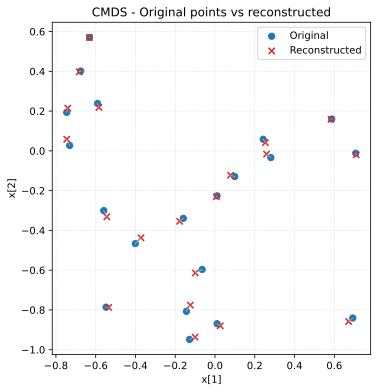

In [6]:
# Generate synthetic data
np.random.seed(2)
n = 20
X_true = np.random.uniform(low=-1.0, high=1.0, size=(n, 2))
noise = 0.05*(np.random.standard_normal(size=(n,n))**2.0)
D2 = squared_dist_matrix(X_true) + noise 

# Solve the convex optimization instance
Z_star, t_star, prob = cmds_minimax(D2)
print_results(prob)
print(f"t* (max squared-distance mismatch) = {t_star:.6g}")

# Reconstruct the embedding and
# plot original vs reconstructed (aligned)
X_rec = gram_to_coords(Z_star, k=2)
plot_mds_comparison(X_true, X_rec, title='CMDS - Original points vs reconstructed', align=True)
